# RTML Midterm Solution, Jan 2020 Semester

This is a solution to the midterm exam.

## Question 2

Suppose you have a data source that outputs pairs $(x_1, x_2)$ distributed according to a 2D Gaussian with mean $(2, 3)$ and covariance
$$ \begin{bmatrix} 4 & -3 \\ -3 & 9 \end{bmatrix}. $$

In PyTorch, build and train a GAN to generate samples as close as possible to this distribution. In the space below, provide your code and a plot that shows a 100-point sample from pg and a 100-point sample from pdata on top of each other in different colors.

**Here is the code**


Epoch 0 generator loss 0.832631 discriminator loss 1.192476
Epoch 1 generator loss 0.831089 discriminator loss 1.185720
Epoch 2 generator loss 0.829596 discriminator loss 1.178954
Epoch 3 generator loss 0.828338 discriminator loss 1.172304
Epoch 4 generator loss 0.827325 discriminator loss 1.165626
Epoch 5 generator loss 0.826645 discriminator loss 1.158934
Epoch 6 generator loss 0.826254 discriminator loss 1.152240
Epoch 7 generator loss 0.826306 discriminator loss 1.145516
Epoch 8 generator loss 0.826667 discriminator loss 1.138770
Epoch 9 generator loss 0.827304 discriminator loss 1.132026
Epoch 10 generator loss 0.828129 discriminator loss 1.125308
Epoch 11 generator loss 0.829028 discriminator loss 1.118666
Epoch 12 generator loss 0.829612 discriminator loss 1.112297
Epoch 13 generator loss 0.830530 discriminator loss 1.106054
Epoch 14 generator loss 0.830865 discriminator loss 1.100122
Epoch 15 generator loss 0.831695 discriminator loss 1.094195
Epoch 16 generator loss 0.832652 d

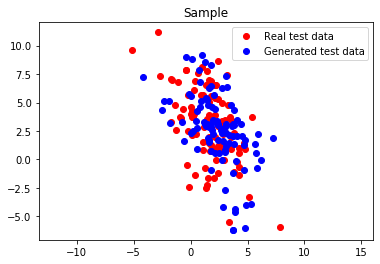

In [71]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import time

N_Z_PARAMS = 8

def noise(size):
    # Generates a 1-d vector of gaussian sampled random values
    n = Variable(torch.randn(size, N_Z_PARAMS))
    return n

def pdata_sample(size):
    mean = np.array([2, 3])
    cov = np.array([[4, -3], [-3, 9]])
    return np.random.multivariate_normal(mean, cov, size)

def plot_data(fig, ax, X1, X2, labels):
    plt.title('Sample')
    ax.plot(X1[:,0], X1[:,1], 'ro', label=labels[0])
    ax.plot(X2[:,0], X2[:,1], 'bo', label=labels[1])
    ax.axis('equal')
    ax.legend()


# Set up data loader with partitioning into minibatches

X = pdata_sample(1000)
samples = torch.Tensor(X)
dataset = torch.utils.data.TensorDataset(samples)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)


class DiscriminatorNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(8, 4),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(4, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = N_Z_PARAMS
        n_out = 2

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(8, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

# Create generator and discriminator

discriminator = DiscriminatorNet()
generator = GeneratorNet()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

def ones_target(size):
    # Tensor containing ones, with shape = size
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    # Tensor containing zeros, with shape = size
    data = Variable(torch.zeros(size, 1))
    return data

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()                               # Reset gradients
    prediction_real = discriminator(real_data)          # Train on real data
    error_real = loss(prediction_real, ones_target(N))  # Calculate error
    error_real.backward()                               # Backpropagate
    prediction_fake = discriminator(fake_data)          # Train on fake data
    error_fake = loss(prediction_fake, zeros_target(N)) # Calculate error
    error_fake.backward()                               # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)                               
    optimizer.zero_grad()                               # Reset gradients
    d_output = discriminator(fake_data)   
    error = loss(d_output, ones_target(N))              # Calculate error
    error.backward()                                    # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error
    return error

num_test_samples = 100
test_data_real = pdata_sample(num_test_samples)
test_noise = noise(num_test_samples)

num_epochs = 2000
d_error_arr = []
g_error_arr = []
fig,ax = plt.subplots(1,1)
for epoch in range(num_epochs):
    n_batches = 0
    g_error = 0
    d_error = 0
    for n_batch, [real_batch] in enumerate(data_loader):
        N = real_batch.size(0) 
        real_data = Variable(real_batch)
        fake_data = generator(noise(N)).detach()
        d_err, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        d_error += d_err.detach().numpy()
        fake_data = generator(noise(N))
        g_err = train_generator(g_optimizer, fake_data)
        g_error += g_err.detach().numpy()
        n_batches = n_batches + 1
    g_error_arr.append(g_error/n_batches)
    d_error_arr.append(d_error/n_batches)
    print('Epoch %d generator loss %f discriminator loss %f' %
          (epoch, g_error_arr[epoch], d_error_arr[epoch]))
    test_data_fake = generator(test_noise).detach()
    
plot_data(fig, ax, test_data_real, test_data_fake, ['Real test data', 'Generated test data'])


## Question 3

Using two 100-point samples from pdata, find the window radius $\sigma$ maximizing the likelihood of a Parzen window model of pdata. The first 100-point sample should be used as the window centers in the model, and the second 100-point sample should be used to calculate the likelihood for different $\sigma$.

**Here is the code and the output**

In [92]:

N_CENTERS = 100
N_PROBES = 100
centers = pdata_sample(N_CENTERS)
probes = pdata_sample(N_PROBES)

sigma = 1.0

def loglike(sigma):
    loglike = 0
    for probe_i in range(N_PROBES):
        p_probe = 0
        for center_i in range(N_CENTERS):
            dist_sq = np.dot(centers[center_i,:] - probes[probe_i,:], centers[center_i,:] - probes[probe_i,:])
            p_probe += np.exp(-dist_sq / 2 / sigma / sigma) / (2 * np.pi * sigma * sigma)
        loglike += np.log(p_probe)
    return loglike

sigma_best = 0
loglike_best = 0
for step in range(20):
    sigma = np.power(2.0, (step-10)/10)
    ll = loglike(sigma)
    print("Log likelihood with sigma = %f: %f" % (sigma, ll))
    if step == 0 or ll > loglike_best:
        loglike_best = ll
        sigma_best = sigma
        
print("Best loglike %f at sigma = %f" % (loglike_best, sigma_best))
sigma = sigma_best


Log likelihood with sigma = 0.500000: -84.931360
Log likelihood with sigma = 0.535887: -69.842678
Log likelihood with sigma = 0.574349: -57.040166
Log likelihood with sigma = 0.615572: -46.205583
Log likelihood with sigma = 0.659754: -37.068154
Log likelihood with sigma = 0.707107: -29.397166
Log likelihood with sigma = 0.757858: -22.995833
Log likelihood with sigma = 0.812252: -17.696365
Log likelihood with sigma = 0.870551: -13.356105
Log likelihood with sigma = 0.933033: -9.854399
Log likelihood with sigma = 1.000000: -7.089987
Log likelihood with sigma = 1.071773: -4.978953
Log likelihood with sigma = 1.148698: -3.453471
Log likelihood with sigma = 1.231144: -2.461329
Log likelihood with sigma = 1.319508: -1.965837
Log likelihood with sigma = 1.414214: -1.945344
Log likelihood with sigma = 1.515717: -2.391618
Log likelihood with sigma = 1.624505: -3.306765
Log likelihood with sigma = 1.741101: -4.699105
Log likelihood with sigma = 1.866066: -6.578949
Best loglike -1.945344 at sigma

## Question 4

Use the Parzen window model of $p_{data}$ you developed in Question 3 to evaluate several different hyperparameter configurations for the GAN developed in Question 2. Include at least two different architectures for both the generator and discriminator. Show the likelihoods for samples from $p_g$ and conclude which hyperparameter configuration is the best.



In [102]:

def loglike_data(probes):
    loglike = 0
    for probe_i in range(probes.shape[0]):
        p_probe = 0
        for center_i in range(N_CENTERS):
            dist_sq = np.dot(centers[center_i,:] - probes[probe_i,:], centers[center_i,:] - probes[probe_i,:])
            p_probe += np.exp(-dist_sq / 2 / sigma / sigma) / (2 * np.pi * sigma * sigma)
        loglike += np.log(p_probe)
    return loglike

# Original generator

test_data_fake = generator(test_noise).detach().numpy()
ll = loglike_data(test_data_fake)
print(ll)

1.6359346774967551


Epoch 0 generator loss 0.832631 discriminator loss 1.192476
Epoch 1 generator loss 0.831089 discriminator loss 1.185720
Epoch 2 generator loss 0.829596 discriminator loss 1.178954
Epoch 3 generator loss 0.828338 discriminator loss 1.172304
Epoch 4 generator loss 0.827325 discriminator loss 1.165626
Epoch 5 generator loss 0.826645 discriminator loss 1.158934
Epoch 6 generator loss 0.826254 discriminator loss 1.152240
Epoch 7 generator loss 0.826306 discriminator loss 1.145516
Epoch 8 generator loss 0.826667 discriminator loss 1.138770
Epoch 9 generator loss 0.827304 discriminator loss 1.132026
Epoch 10 generator loss 0.828129 discriminator loss 1.125308
Epoch 11 generator loss 0.829028 discriminator loss 1.118666
Epoch 12 generator loss 0.829612 discriminator loss 1.112297
Epoch 13 generator loss 0.830530 discriminator loss 1.106054
Epoch 14 generator loss 0.830865 discriminator loss 1.100122
Epoch 15 generator loss 0.831695 discriminator loss 1.094195
Epoch 16 generator loss 0.832652 d

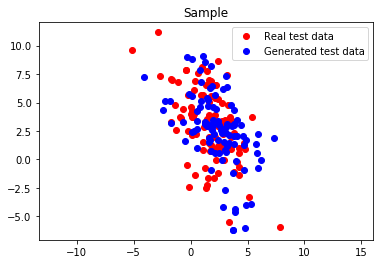

In [104]:
class GeneratorNet2(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet2, self).__init__()
        n_features = N_Z_PARAMS
        n_out = 2

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(4, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x

# Create generator and discriminator

discriminator2 = DiscriminatorNet()
generator2 = GeneratorNet2()

def train_discriminator2(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()                               # Reset gradients
    prediction_real = discriminator2(real_data)          # Train on real data
    error_real = loss(prediction_real, ones_target(N))  # Calculate error
    error_real.backward()                               # Backpropagate
    prediction_fake = discriminator2(fake_data)          # Train on fake data
    error_fake = loss(prediction_fake, zeros_target(N)) # Calculate error
    error_fake.backward()                               # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator2(optimizer, fake_data):
    N = fake_data.size(0)                               
    optimizer.zero_grad()                               # Reset gradients
    d_output = discriminator2(fake_data)   
    error = loss(d_output, ones_target(N))              # Calculate error
    error.backward()                                    # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error
    return error

num_epochs = 2000
d_error_arr_2 = []
g_error_arr_2 = []
fig,ax = plt.subplots(1,1)
for epoch in range(num_epochs):
    n_batches = 0
    g_error = 0
    d_error = 0
    for n_batch, [real_batch] in enumerate(data_loader):
        N = real_batch.size(0) 
        real_data = Variable(real_batch)
        fake_data = generator2(noise(N)).detach()
        d_err, d_pred_real, d_pred_fake = train_discriminator2(d_optimizer, real_data, fake_data)
        d_error += d_err.detach().numpy()
        fake_data = generator2(noise(N))
        g_err = train_generator2(g_optimizer, fake_data)
        g_error += g_err.detach().numpy()
        n_batches = n_batches + 1
    g_error_arr.append(g_error/n_batches)
    d_error_arr.append(d_error/n_batches)
    print('Epoch %d generator loss %f discriminator loss %f' %
          (epoch, g_error_arr[epoch], d_error_arr[epoch]))
    test_data_fake = generator(test_noise).detach()
    
plot_data(fig, ax, test_data_real, test_data_fake, ['Real test data', 'Generated test data'])



(TBD: complete runs with several architectures and compare the log likelihoods of the different models)